In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

from tqdm.auto import trange
from PIL import Image

from utils import total_variation, load_image, G, MEAN, STD

# Retrieve device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model

In [4]:
# Load model
vgg16 = models.vgg16(pretrained=True).to(device)

# Switch model to inference mode
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# Freeze weights
for param in vgg16.parameters():
    param.requires_grad = False

In [6]:
vgg16_layers = [
    vgg16.features[:10],
    vgg16.features[10:16],
    vgg16.features[16:25],
]

"""
vgg16_layers = [
    vgg16.features[:5],
    vgg16.features[5:10],
    vgg16.features[10:17],
]
"""

"""
vgg16_layers = [
    vgg16.features[:2],
    vgg16.features[2:4],
    vgg16.features[4:6],
]
"""

'\nvgg16_layers = [\n    vgg16.features[:2],\n    vgg16.features[2:4],\n    vgg16.features[4:6],\n]\n'

In [7]:
vgg16_truncated = vgg16.features[:25]
vgg16_truncated = vgg16_truncated.to(device)

In [8]:
vgg16_truncated

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [9]:
dog, dog_torch = load_image("dog.jpg", crop=(400,0,1000,600), ratio="min")
dog_brown, dog_brown_torch = load_image("chien_brun.jpg", crop=(400,0,1000,563), ratio="min")

munch, munch_torch = load_image("munch.jpg", ratio="min")
van_gogh, van_gogh_torch = load_image("van_gogh.jpg", ratio="min")

volcan, volcan_torch = load_image("volcan.jpg", ratio="min")

In [10]:
dog_torch.shape, munch_torch.shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

VGG-16 attend en input un batch d'images (64) d'au moins 224x224.

unsqueeze permet de rajouter une dimension en plus.

In [11]:
dog_output = vgg16_truncated(dog_torch.unsqueeze(0).to(device))
dog_output.requires_grad = False
dog_output.shape

torch.Size([1, 512, 14, 14])

In [12]:
def compute_gram(vgg16_layers, array_torch):
    """
    Args:
        vgg16 : PyTorch model
        array_torch
    """
    outputs = [vgg16_layers[0](array_torch.unsqueeze(0).to(device))]
    
    for i in range(1,len(vgg16_layers)):
        outputs.append(vgg16_layers[i](outputs[-1]))
    
    grams = [G(output) @ G(output).T for output in outputs]

    return grams

In [13]:
def mix_two_pictures(content, style, base_image, lr=5e-2, alpha=1, beta=10, lam_content=0.1, lam_style=0.2, iterations=100):

    img = base_image.clone()
    img.requires_grad = True
    
    optim = torch.optim.Adam([img], lr=lr)
    
    content_output = vgg16_layers[0](content.unsqueeze(0).to(device))
    content_output.requires_grad = False
    
    style_grams = compute_gram(vgg16_layers, style)
    
    norm_0 = style_grams[0].shape[0]**(-2)
    norm_1 = style_grams[1].shape[0]**(-2)
    norm_2 = style_grams[2].shape[0]**(-2)
    
    for i in trange(iterations):
        
        optim.zero_grad()
        
        output_0 = vgg16_layers[0](img.unsqueeze(0).to(device))
        output_1 = vgg16_layers[1](output_0)
        output_2 = vgg16_layers[2](output_1)
        
        loss_content = 0
        loss_style = 0
                
        # Content
        if alpha != 0:
            loss_content = F.mse_loss(output_0, content_output) + lam_content * total_variation(output_0)

        # Style
        if beta != 0:
            gram_0 = G(output_0) @ G(output_0).T
            gram_1 = G(output_1) @ G(output_1).T
            gram_2 = G(output_2) @ G(output_2).T

            loss_0 = norm_0 * F.mse_loss(gram_0, style_grams[0]) + lam_style * total_variation(gram_0)
            loss_1 = norm_1 * F.mse_loss(gram_1, style_grams[1]) + lam_style * total_variation(gram_1)
            loss_2 = norm_2 * F.mse_loss(gram_2, style_grams[2]) + lam_style * total_variation(gram_2)

            loss_style = 1/3 * loss_0 + 1/3 * loss_1 + 1/3 * loss_2
        
        # Sum
        loss = alpha * loss_content + beta * loss_style
        loss.backward()

        if i%(iterations//20) == 0:
            print("Loss ",i, loss.data)

        optim.step()
        #scheduler.step()

    return img

In [14]:
def display_img(mix_img):
    """Display image.
    
    Note : clipping is important. The NN outputs image with some pixels outside from [0,255]
    """
    img_result = ((mix_img.permute(1,2,0).cpu() * STD.T + MEAN.T)*255).clip(0,255)
    return Image.fromarray(img_result.detach().numpy().astype("uint8"))

In [15]:
noise = torch.randint(0, 255+1, dog_torch.shape)
noise = (noise/255)
noise = (noise - MEAN)/STD

#noise += dog_torch

noise = noise.to(device)

In [16]:
mix_img = mix_two_pictures(dog_torch, munch_torch, noise, lr=1e-1, alpha=1, beta=0.04, lam_content=0.1, lam_style=0, iterations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss  0 tensor(17907.2832, device='cuda:0')
Loss  50 tensor(107.8725, device='cuda:0')
Loss  100 tensor(44.9828, device='cuda:0')
Loss  150 tensor(32.6572, device='cuda:0')
Loss  200 tensor(27.1372, device='cuda:0')
Loss  250 tensor(23.8216, device='cuda:0')
Loss  300 tensor(21.5495, device='cuda:0')
Loss  350 tensor(19.8821, device='cuda:0')
Loss  400 tensor(18.6018, device='cuda:0')
Loss  450 tensor(17.5774, device='cuda:0')
Loss  500 tensor(16.7165, device='cuda:0')
Loss  550 tensor(15.9803, device='cuda:0')
Loss  600 tensor(15.3444, device='cuda:0')
Loss  650 tensor(14.7803, device='cuda:0')
Loss  700 tensor(14.2729, device='cuda:0')
Loss  750 tensor(13.8210, device='cuda:0')
Loss  800 tensor(13.4155, device='cuda:0')
Loss  850 tensor(13.0452, device='cuda:0')
Loss  900 tensor(12.6983, device='cuda:0')
Loss  950 tensor(12.3769, device='cuda:0')


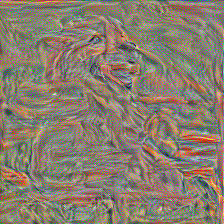

In [17]:
display_img(mix_img)

In [18]:
mix_img = mix_two_pictures(dog_torch, van_gogh_torch, noise, lr=1e-1, alpha=1, beta=0.04, lam_content=0.1, lam_style=0, iterations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss  0 tensor(16439.8145, device='cuda:0')
Loss  50 tensor(59.0074, device='cuda:0')
Loss  100 tensor(28.7427, device='cuda:0')
Loss  150 tensor(23.6830, device='cuda:0')
Loss  200 tensor(21.1935, device='cuda:0')
Loss  250 tensor(19.5775, device='cuda:0')
Loss  300 tensor(18.3865, device='cuda:0')
Loss  350 tensor(17.4422, device='cuda:0')
Loss  400 tensor(16.6655, device='cuda:0')
Loss  450 tensor(16.0062, device='cuda:0')
Loss  500 tensor(15.4286, device='cuda:0')
Loss  550 tensor(14.9132, device='cuda:0')
Loss  600 tensor(14.4537, device='cuda:0')
Loss  650 tensor(14.0406, device='cuda:0')
Loss  700 tensor(13.6656, device='cuda:0')
Loss  750 tensor(13.3232, device='cuda:0')
Loss  800 tensor(13.0110, device='cuda:0')
Loss  850 tensor(12.7191, device='cuda:0')
Loss  900 tensor(12.4455, device='cuda:0')
Loss  950 tensor(12.1876, device='cuda:0')


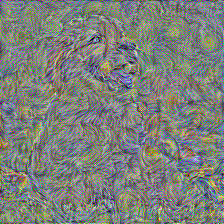

In [19]:
display_img(mix_img)

In [20]:
mix_img = mix_two_pictures(dog_torch, dog_brown_torch, noise, lr=1e-1, alpha=1, beta=0.04, lam_content=0.1, lam_style=0, iterations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss  0 tensor(19554.0332, device='cuda:0')
Loss  50 tensor(136.3749, device='cuda:0')
Loss  100 tensor(61.5212, device='cuda:0')
Loss  150 tensor(40.2622, device='cuda:0')
Loss  200 tensor(30.6907, device='cuda:0')
Loss  250 tensor(25.3608, device='cuda:0')
Loss  300 tensor(22.0141, device='cuda:0')
Loss  350 tensor(19.7110, device='cuda:0')
Loss  400 tensor(17.9825, device='cuda:0')
Loss  450 tensor(16.6245, device='cuda:0')
Loss  500 tensor(15.5401, device='cuda:0')
Loss  550 tensor(14.6473, device='cuda:0')
Loss  600 tensor(13.8792, device='cuda:0')
Loss  650 tensor(13.2070, device='cuda:0')
Loss  700 tensor(12.6161, device='cuda:0')
Loss  750 tensor(12.0883, device='cuda:0')
Loss  800 tensor(11.6062, device='cuda:0')
Loss  850 tensor(11.1585, device='cuda:0')
Loss  900 tensor(10.7437, device='cuda:0')
Loss  950 tensor(10.3579, device='cuda:0')


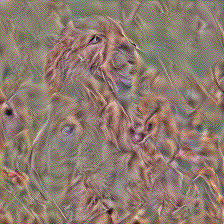

In [21]:
display_img(mix_img)

In [22]:
mix_img = mix_two_pictures(dog_torch, volcan_torch, noise, lr=1e-1, alpha=1, beta=0.04, lam_content=0.1, lam_style=0, iterations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss  0 tensor(18719.9473, device='cuda:0')
Loss  50 tensor(109.2648, device='cuda:0')
Loss  100 tensor(53.2426, device='cuda:0')
Loss  150 tensor(38.3180, device='cuda:0')
Loss  200 tensor(30.9981, device='cuda:0')
Loss  250 tensor(26.6574, device='cuda:0')
Loss  300 tensor(23.8236, device='cuda:0')
Loss  350 tensor(21.7785, device='cuda:0')
Loss  400 tensor(20.2156, device='cuda:0')
Loss  450 tensor(18.9648, device='cuda:0')
Loss  500 tensor(17.9142, device='cuda:0')
Loss  550 tensor(17.0050, device='cuda:0')
Loss  600 tensor(16.2065, device='cuda:0')
Loss  650 tensor(15.5021, device='cuda:0')
Loss  700 tensor(14.8630, device='cuda:0')
Loss  750 tensor(14.2909, device='cuda:0')
Loss  800 tensor(13.7618, device='cuda:0')
Loss  850 tensor(13.2809, device='cuda:0')
Loss  900 tensor(12.8460, device='cuda:0')
Loss  950 tensor(12.4436, device='cuda:0')


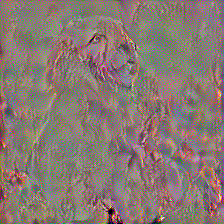

In [23]:
display_img(mix_img)